### 1. Data
We will train our model using UCI Machine Learning's SMS spam collection dataset available <a href = "https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset">here</a>.

### 2. Preparation
#### 2.1. Import libraries and lad the UCI's spam dataset

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the UCI's Spam dataset
df = pd.read_csv("./spam.csv", encoding='latin-1')

#### 2.2. Explore the data
Before we do anything, we are going to explore the data to think about the next steps.

In [2]:
# View the first 5 entries
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Describe the data
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


Based on the above basic exploration, it seems that (1) we can remove the last 3 columns and (2) remove the duplicates in v2.

### 3. Clean the data
#### 3.1. Remove unnecessary columns 
We are going to drop the last three columns and change the variable names to "label" and "message".

In [4]:
# Drop the last 3 columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],
        inplace=True)

# Change the column names
df.columns = ['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### 3.2. Check for missing values and duplicates

In [5]:
# Check for missing values
df.isnull().sum()

label      0
message    0
dtype: int64

There are no missing values in the remaining two columns.

As mentioned above, we have some duplicates. Let's remove them.

In [6]:
# Remove duplicates
df.drop_duplicates(keep='first', inplace = True)

# Check duplicates
df.duplicated().sum()

0

### 4. Exploratory Data Analysis (EDA)
Before we proceed with modeling, let's perform an EDA and better understand the data.

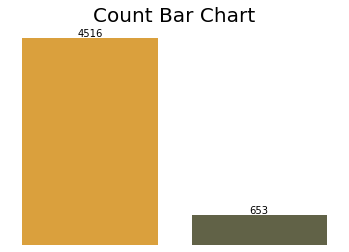

In [7]:
# Create counts and define labels and colors
counts = [len(df[df['label']=='ham']), 
          len(df[df['label']=='spam'])]
labels = 'Ham', 'Spam'
colors = ["#DAA03DFF", "#616247FF"]

# Make it look nice - remove tics and labels
fig1, ax1 = plt.subplots()
ax1.bar(labels, counts, color = colors)
plt.tick_params(
    left=False,
    bottom=False,    
    labelleft=False,
    labelbottom=False)
plt.box(False)
plt.title("Count Bar Chart", fontsize = 20)

# Show values for each bar
for bars in ax1.containers:
    ax1.bar_label(bars)
plt.show()

We have an imbalanced dataset with 4,516 normal messages and 653 spam messages. 

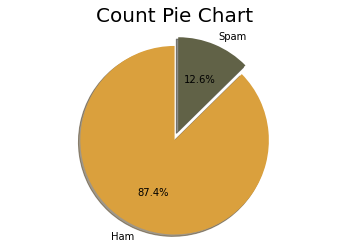

In [8]:
# Pie Chart
fig2, ax2 = plt.subplots()

ax2.pie(counts,            # Plot counts
        labels=labels,     # Use the labels defined above
        colors=colors,     # Use the colors defined above
        explode=(0, 0.1),  # Only "explode" the 2nd slice
        autopct='%1.1f%%', # Show %
        shadow=True,       # Shadow
        startangle=90)     # Rotate
ax2.axis('equal')          # Ensures that the pie is a circle
plt.title("Count Pie Chart", fontsize = 20)
plt.show()

The pie chart above shows the same inference: we have an imbalanced dataset.

### 5. Data preprocessing
Next, we are going to perform preprocessing on the message. Specifically, we are going to perform the following:
- Covert to lower cases
- Remove punctuations and numbers: There are various ways to remove punctuations, but based on <a href = "https://towardsdatascience.com/how-to-efficiently-remove-punctuations-from-a-string-899ad4a059fb">this article</a>, the translate method is the fastest method.
- Tokenization: It refers to the process of splitting strings. It allows us to manipulate words or conduct analyses on them. We will tokenize texts into words.
- Stop word: It refers to are words that do not have much meaning and thus removed for many nlp projects. Some examples include “the”, “a”, “so”, “what”. There are various libraries, but for this analysis, we will use the SciKit Learn's list.
- Lemmatization: Covert the word to its basic form (e.g, ran = > run)
 
#### 5.1. Preparation

In [9]:
# Libraries
import string
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')   # Required for tokenization
nltk.download('wordnet') # Required for lemmatization

# Instantiate
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# More stop words
stop_words = ['å£'] + list(ENGLISH_STOP_WORDS)

# Exclusion list of punctuations and numbers
exclist = string.punctuation + string.digits

# Print the exclusion list
print(exclist)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Young\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Young\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### 5.2. Conduct preprocessing
Let's create a function that performs all the preprocessing steps listed above.

In [10]:
# Create a Function
def clean_texts(text):
    """ Function to perform preprocessing """
    
    # Convert to lower cases
    text = text.lower()
    
    # Remove punctuations and numbers
    text = text.translate(str.maketrans("", "", exclist))
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens
    clean_text = " ".join(tokens)
    
    # Return the output
    return clean_text

Apply the function to all the messages.

In [11]:
# Preprocessing
df['clean_message'] = df['message'].apply(clean_texts)
df.head()

,label,message,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazi avail bugi n great world la...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st t...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live


### 6. Word clouds and word counts
Since we cleaned the messages, let's conduct a bit more EDA and examine the difference in word counts between spam vs. non-spam messages.
#### 6.1. Word Clouds - Spam

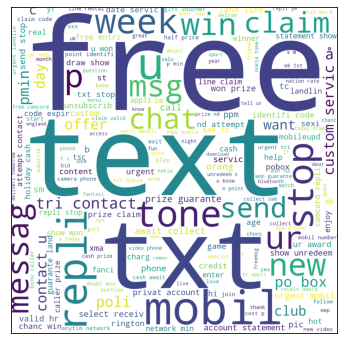

In [12]:
# Import library
from wordcloud import WordCloud

# Instantiate Word Cloud
wc = WordCloud(width=1500,
               height=1500,
               min_font_size=10,
               background_color='white')

# Generate a word cloud for spam messages
plt.figure(figsize = (24, 6))
spam_wc = wc.generate(df[df['label'] == "spam"]['clean_message'].str.cat(sep=" "))
plt.xticks([])
plt.yticks([])
plt.imshow(spam_wc);

Some notable high-frequency words include free, text, offer, claim, and win. It makes sense that these words appear a lot in spam messages.

#### 6.2. Word Clouds - Non-Spam

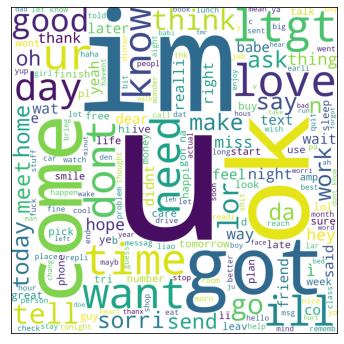

In [13]:
# Generate a word cloud for non-spam messages
plt.figure(figsize = (24, 6))
ham_wc = wc.generate(df[df['label'] == "ham"]['clean_message'].str.cat(sep=" "))
plt.xticks([])
plt.yticks([])
plt.imshow(ham_wc);

Normal messages have very different high-frequent words: u, ok, got, I'm, love, etc. Once again, this plot also makes sense.

#### 6.3. Word Count Plots - Spam
The inferences from word count plots should be the same as the word clouds but it's always good to see the count plots to make sure we didn't miss anything. If we identify some words we think should be excluded, we can go back to the preprocessing step and add them to the list of stop words.

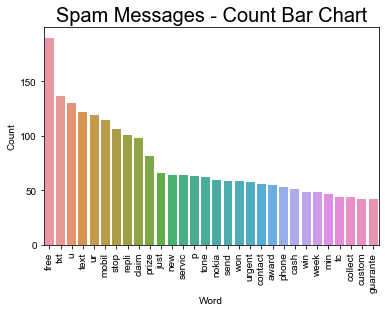

In [14]:
# Import libraries
from collections import Counter
import seaborn as sns

# Create a function
def count_plot(label):
    """ 
    This function creates the following:
    (1) Corpus of messages
    (2) Dataframe of the most common 30 words 
    (3) Count plot
    """
    
    # Create corpus (collection of texts) for spams
    corpus = []
    for msg in df[df['label'] == label]['clean_message'].tolist():
        for word in msg.split():
            corpus.append(word)

    # Create a datafram of most common 30 words
    common_words = pd.DataFrame(Counter(corpus).most_common(30))
    common_words.columns = ('Word', 'Count')
    common_words.head()

    # Plot a count bar chart for spam messages
    sns.barplot(x= common_words['Word'], y=common_words['Count'])
    sns.set(font_scale = 1.5)
    plt.xticks(rotation='vertical')
    
    plt.title("{} Messages - Count Bar Chart".format(label.capitalize()),
             fontsize = 20)
    plt.show()

# Plot spam message count bar chart
count_plot("spam")

#### 6.4. Word Count Plots - Ham

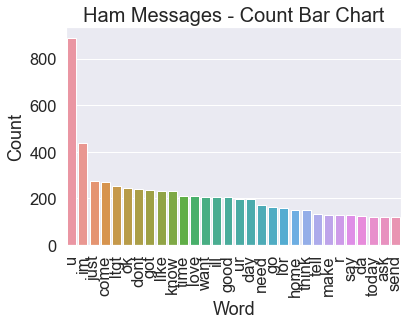

In [15]:
# Plot spam message count bar chart
count_plot("ham")

Everything looks good! Let's move on to the next step.

### 7. Vectorization
Machines cannot read texts. Thus we have to convert them to numbers. This process is called vectorization or word embeddings.

#### 7.1. Test and training set split
First, let's split the data into test and training sets to avoid data leakage during the vectorization step.

In [16]:
# Import library
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode the label
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

# Split the samples into train and test sets
X_train, X_test, y_train, y_test = \
train_test_split(df['message'], df['label'], 
                 test_size = 0.2, random_state=1)

# View the shapes of all dataframes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135,), (1034,), (4135,), (1034,))

#### 7.2. TF-IDF
TF-IDF is one of the most popular ways to vectorize corpus. TF-IDF stands for "Term Frequency — Inverse Document Frequency". Term Frequency measures the frequency of a word in a document. Inverse Document Frequency is the natural log of the inverse of document frequency, which is the number of documents where the word appears.

In [17]:
# Import library
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate
vectorizer = TfidfVectorizer()

# Fit the training data (only the training data)
vectorizer.fit(X_train)

# Vectorize 
X_train_vec = vectorizer.transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Display the the vectors
X_train_vec, X_test_vec

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

### 8. Model building
There are numerous classifiers we can use. For this exercise, we will start with Artificial Neural Network (ANN) and turn to other classifiers if the performance is not satisfying.

#### 8.1. Compile

In [18]:
# Import library
import tensorflow as tf

# Instantiate
ann_model = tf.keras.models.Sequential()

# Add layers
ann_model.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann_model.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

ann_model.compile(optimizer='adam', 
            loss = 'binary_crossentropy', 
            metrics = ['accuracy']) 
#Compiling
ann_model.fit(X_train_vec, y_train.values, batch_size=32, epochs=10)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4135 samples
Epoch 1/10
4135/4135 [==============================] - 0s 79us/sample - loss: 0.5549 - acc: 0.8738
Epoch 2/10
4135/4135 [==============================] - 0s 56us/sample - loss: 0.2768 - acc: 0.9033
Epoch 3/10
4135/4135 [==============================] - 0s 55us/sample - loss: 0.1284 - acc: 0.9732
Epoch 4/10
4135/4135 [==============================] - 0s 55us/sample - loss: 0.0670 - acc: 0.9886
Epoch 5/10
4135/4135 [==============================] - 0s 55us/sample - loss: 0.0407 - acc: 0.9937
Epoch 6/10
4135/4135 [==============================] - 0s 55us/sample - loss: 0.0271 - acc: 0.9947
Epoch 7/10
4135/4135 [==============================] - 0s 54us/sample - loss: 0.0189 - acc: 0.9969
Epoch 8/10
4135/4135 [==============================] - 0s 55us/sample - loss: 0.0137 - acc: 0.9976
Epo

#### 8.2. Predict
Now that we trained the model, let's set the decision boundary at 0.5 and classify everything above 0.5 as spam messages.

In [19]:
y_predict = (ann_model.predict(X_test_vec) > 0.5)

### 9. Evaluation
In this section, we will evaluate our model using various measures. 

#### 9.1. Confusion Matrix

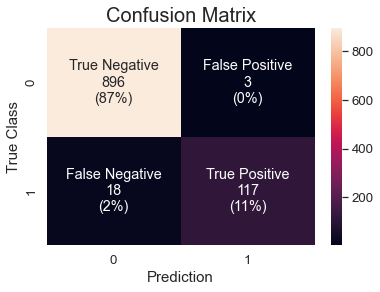

In [20]:
# Import library
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

# Create a function to tabulate Confusion Matrix
def cm_function(matrix_input, y_test_input, title):
    ''' Function to plot Confusion Matrix '''
    
    # Gather values and labels that will be used in the matrix
    group_names = ['True Negative','False Positive',
          'False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value 
          in matrix_input.flatten()]
    group_percentages = ["({0:0.0%})".format(value) 
          for value in matrix_input.flatten()/y_test_input.count()]
    
    # Create 4 texts that will be shown in each box of the matrix
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    # Plot the matrix and adjust the format
    sns.set(font_scale = 1.2)
    fig = sns.heatmap(matrix_input, fmt='', annot = labels)
    plt.title(title, fontsize=20)
    plt.xlabel("Prediction", fontsize = 15)
    plt.ylabel("True Class", fontsize = 15) 
    plt.show()

# Process and tabulate the Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
cm_function(cm, y_test, 
            "Confusion Matrix")

The confusion matrix above shows that our model did a great job!

#### 9.2. Accuracy, Precision, Recall, F1-Score
To better evaluate the model, let's report some popular evaluations metrics.

In [21]:
# Report accuracy, precision, and recall
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       899
           1       0.97      0.87      0.92       135

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [24]:
The ANN model has very good accuracy, precision, recal, and f1-score.

#### 9.3. Test some messages
As the last evaluation step, let's test out whether the following typical message is correctly classified as spam.

SyntaxError: invalid syntax (3994548050.py, line 1)

In [25]:
ann_model.predict(vectorizer.transform(["you won $99"]).toarray())

array([[0.7905629]], dtype=float32)

The spam prediction is well above 0.5, so the detector will correctly predict this message as a spam message. Good!

Next, let's try a normal message.

In [26]:
ann_model.predict(vectorizer.transform(["Hey, Young. Should we meet at 5?"]).toarray())

array([[0.00237715]], dtype=float32)

The spam prediction is very low. The detector will correctly predict the above message as a normal message. 

#### 10. Save the model for deployment
The last step is to save the trained model in the json format and the weights in the hdf5 format.

In [28]:
from tensorflow.keras.models import model_from_json

# serialize model to json
json_model = ann_model.to_json()

# Save the model architecture to JSON file
with open('ann_model.json', 'w') as json_file:
    json_file.write(json_model)

    #saving the weights of the model 
ann_model.save_weights('ann_model_weights.h5')